# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Michael | Shi | Michael Shi, 11-08-2024 | 8 | 25% |
| Member 2: | Hlayn | Toe Wai | Hlayn Toe Wai, 11-08-2024| 8 | 25% |
| Member 3: | Hsu Hsu | Sandi| Hsu Hsu Sandi, 11-08-2024 | 8 | 25% |
| Member 4: | Sheinn | Min Thu | Sheinn Min Thu, 11-08-2024 | 8 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

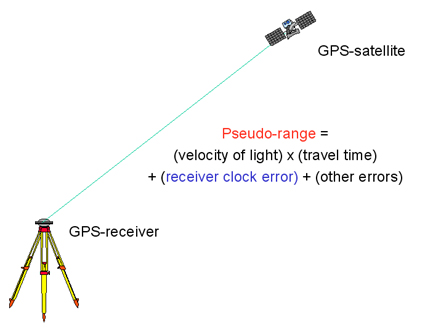

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [6]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric range (distance) between receiver and each satellite
    rho = euclidean_norm(r_pos, s_pos)
    
    # Calculate the predicted pseudoranges
    predicted_pseudorange = rho - cdT  # cdT is the clock offset
    
    # Calculate the residuals between observed and predicted pseudoranges
    residuals = pseudorange - predicted_pseudorange
    
    # Compute the sum of squared residuals (cost)
    L = np.sum(residuals ** 2)
    
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [7]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric range (distance) between receiver and each satellite
    rho = euclidean_norm(r_pos, s_pos)  # Predicted range without clock offset
    
    # Predicted pseudorange, accounting for clock offset
    predicted_pseudorange = rho - cdT

    # Residuals: observed pseudorange - predicted pseudorange
    residuals = pseudorange - predicted_pseudorange

    # Number of satellite measurements
    n = len(pseudorange)

    # Partial derivatives of the range with respect to receiver coordinates and clock offset
    d_rho_dx = -(s_pos[:, 0] - r_pos[0]) / rho  # ∂ρ/∂x_r
    d_rho_dy = -(s_pos[:, 1] - r_pos[1]) / rho  # ∂ρ/∂y_r
    d_rho_dz = -(s_pos[:, 2] - r_pos[2]) / rho  # ∂ρ/∂z_r
    d_rho_dcdt = -1                             # ∂ρ/∂cdT (clock offset term)

    # Gradient of the cost function with respect to each unknown (with 2/n scaling factor)
    dL_dx = -2 / n * np.sum(residuals * d_rho_dx)
    dL_dy = -2 / n * np.sum(residuals * d_rho_dy)
    dL_dz = -2 / n * np.sum(residuals * d_rho_dz)
    dL_dcdt = -2 / n * np.sum(residuals * d_rho_dcdt)

    # Combine gradient components into a single array
    grad = np.array([dL_dx, dL_dy, dL_dz, dL_dcdt])
    
    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [8]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - (learning_rate * grad)

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
# Call gradient_descent function
optimized_params = gradient_descent(pseudorange, sat_pos)

# Extract the optimized position and clock offset from the result
optimized_position = optimized_params[:3]
optimized_cdT = optimized_params[3]

# Calculate final position errors
final_position_error = optimized_position - GroundTruth

# Calculate the final cost value
final_cost = cost_function(optimized_position, optimized_cdT, sat_pos, pseudorange)

# Calculate the final gradient values
final_gradient = gradient(optimized_position, optimized_cdT, sat_pos, pseudorange)

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors (x_r, y_r, z_r):", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46487283e+00]
Final Position Errors (x_r, y_r, z_r): [-3.06410407 -2.35577741  3.80056311]
Number of Steps Taken for Convergence: 3151
Final Cost Value: 6.197101203134901
Final Gradient Values: [ 4.66697971e-05  2.60043151e-04 -7.99227452e-04  4.53108414e-04]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

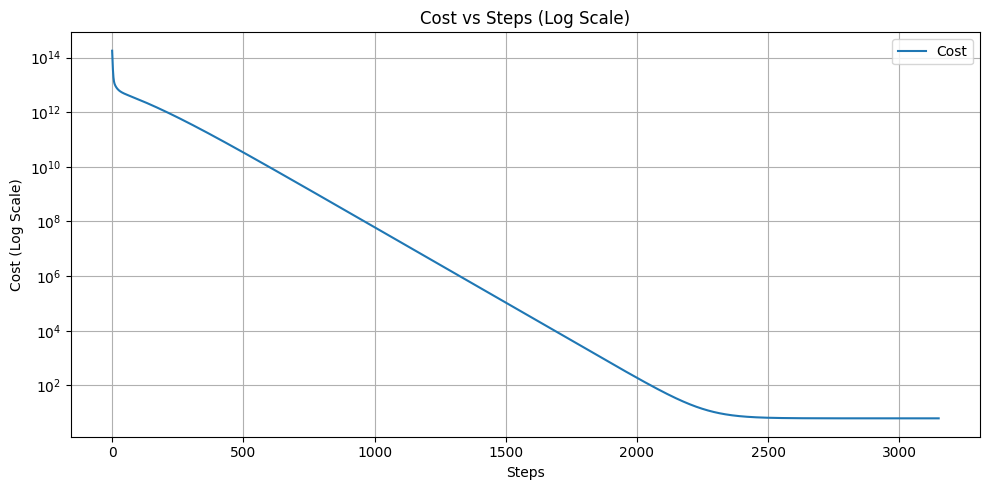

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Plot cost vs. steps with a logarithmic scale on the y-axis
ax.semilogy(arr_cost, label='Cost')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')
ax.set_title('Cost vs Steps (Log Scale)')
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows a rapid decrease in cost during the initial steps, suggesting
# that the model quickly reduces the error. As the steps progress, the cost
# reduction slows down, and plateaus near convergence at around steps 2500-3000. This pattern is 
# typical in gradient descent when getting close to the optimal solution.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

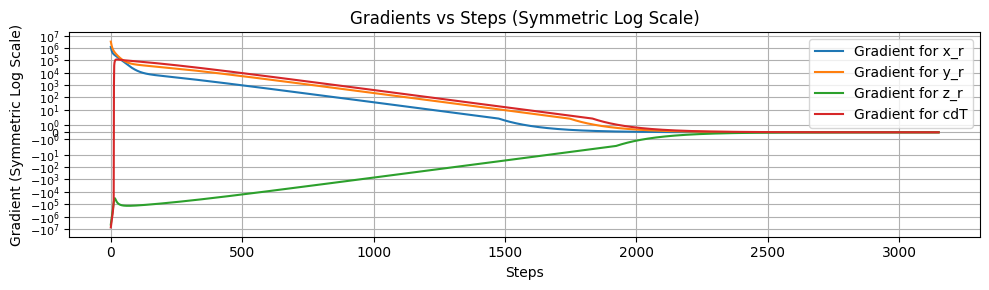

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Convert arr_grad (a list of gradient arrays) to a numpy array
grad_array = np.array(arr_grad)

# Plot each gradient component
ax.plot(grad_array[:, 0], label='Gradient for x_r')
ax.plot(grad_array[:, 1], label='Gradient for y_r')
ax.plot(grad_array[:, 2], label='Gradient for z_r')
ax.plot(grad_array[:, 3], label='Gradient for cdT')

# Use symmetric log scale for y-axis
ax.set_yscale('symlog')
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient (Symmetric Log Scale)')
ax.set_title('Gradients vs Steps (Symmetric Log Scale)')
ax.legend()
ax.grid(True)

# Adjust tick label size
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()

# Comment on the pattern
# The gradients decrease sharply in the initial steps, showing large updates to the parameters.
# As the steps progress, the gradients gradually approach zero at around 2500-3000 steps, indicating convergence.
# This pattern confirms that the gradient descent algorithm is effectively minimizing the cost,
# with smaller adjustments as it nears the optimal solution.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

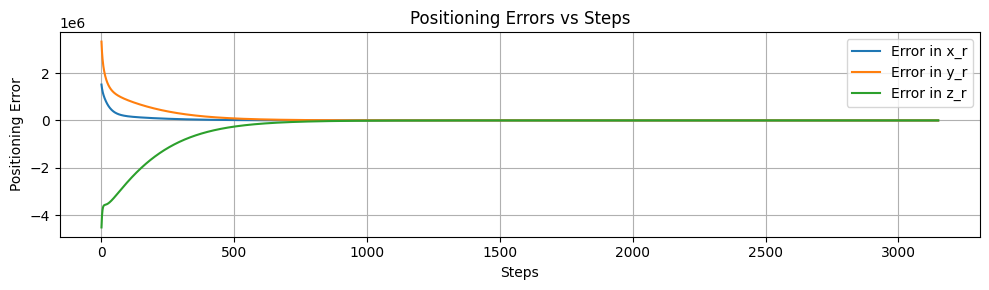

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Convert arr_err (list of error arrays) to a numpy array
error_array = np.array(arr_err)

# Plot the positioning errors
ax.plot(error_array[:, 0], label='Error in x_r')
ax.plot(error_array[:, 1], label='Error in y_r')
ax.plot(error_array[:, 2], label='Error in z_r')

# Label the axes and add a title
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')
ax.set_title('Positioning Errors vs Steps')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot pattern shows a rapid initial decrease in positioning errors for x_r, y_r, and z_r 
# within the first 500 steps, indicating the gradient descent algorithm quickly brings the estimated 
# position closer to the true position. After this, the errors gradually approach zero, 
# with x_r, y_r, and z_r all plateauing near zero by around 1,500-2,000 steps. This plateau suggests 
# the algorithm has converged.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
# Set learning rate to 0.01 and max iterations to 100000
learning_rate = 0.01
max_iters = 100000  # You may adjust this if needed based on convergence speed

# Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with learning rate = 0.01
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=max_iters)

# Print the metrics
print("Learning rate:", learning_rate)
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors (x_r, y_r, z_r):", optimized_params_2[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange))
print("Final Gradient Values:", gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange))

Converged !
Learning rate: 0.01
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44938808e+00]
Final Position Errors (x_r, y_r, z_r): [-3.06250913 -2.34689044  3.77324973]
Number of Steps Taken for Convergence: 29782
Final Cost Value: 6.197817211057162
Final Gradient Values: [ 0.00014787  0.00082393 -0.00253228  0.00143562]


In [ ]:
# Set learning rate to 0.001 and max iterations to 1000000
learning_rate = 0.001
max_iters = 1000000 

#Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with learning rate = 0.001
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=max_iters)

# Print the metrics
print("\nLearning rate:", learning_rate)
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Errors (x_r, y_r, z_r):", optimized_params_3[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange))
print("Final Gradient Values:", gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange))

Converged !

Learning rate: 0.001
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162950e+06  4.95248531e+06 -6.40013170e+00]
Final Position Errors (x_r, y_r, z_r): [-3.05743569 -2.31862133  3.6863669 ]
Number of Steps Taken for Convergence: 279686
Final Cost Value: 6.205048505340579
Final Gradient Values: [ 0.00046978  0.00261762 -0.00804505  0.00456098]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
1. With a learning rate of 0.1, the algorithm originally converged in 3151 steps. With a learning rate of 0.01, the algorithm converged in 29782 steps. And with a learning rate of 0.001, it took 279686 steps to converge. This shows that a higher learning rate allows the algorithm to converge faster because it makes larger updates to the parameters in each iteration. However, a learning rate that is too high could risk divergence, so there is a balance to find. The final optimized parameters and position errors are very similar across all learning rates, indicating that despite the difference in convergence speed, the solution itself is stable and consistent across learning rates. 

2. LSE quickly finds the optimal solution by directly minimizing the residuals and often requires fewer steps. In our case, LSE converged in just 5 iterations. Gradient Descent, however, reaches the solution gradually by following the cost function's gradient. It required 3151 steps with a learning rate of 0.1, 29782 steps with a learning rate of 0.01 and 279686 steps with 0.001. This method is slower but more flexible for nonlinear problems, where LSE may not be directly applicable. In our case, with a small dataset and fewer parameters, LSE was efficient and quick. However, with a larger dataset or higher-dimensional data, Gradient Descent would likely be more effective and practical for finding an optimal solution.
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [15]:
!pip install ucimlrepo

In [16]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data['features'])  #
y = pd.Series(phishing_websites.data['targets']['result'], name="Target")  # Convert targets to a Series

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

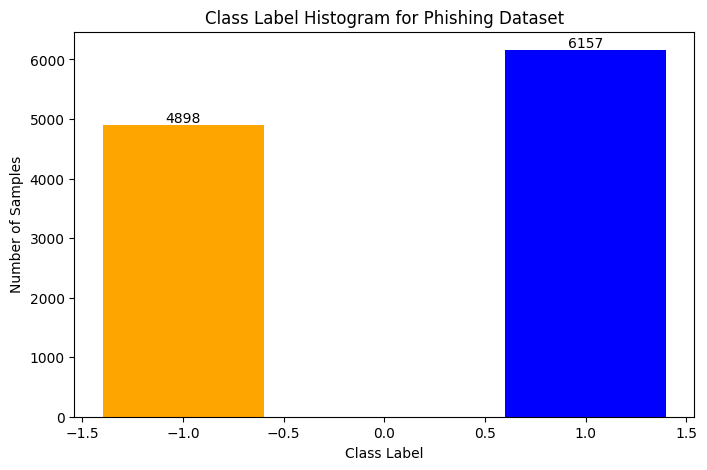

In [17]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()  # Count the occurrences of each class in y

# Plot the histogram for each class label
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Label Histogram for Phishing Dataset")

# Display exact values for each bin in the histogram
for index, value in zip(class_counts.index, class_counts.values):
    plt.text(index, value + 50, str(value), ha='center')  # Display count above each bar

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [18]:
from sklearn.model_selection import train_test_split
 
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
 
 
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [19]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Function that calculates all required information
def evaluate_model(X, y, data_label):
    # Split data into 70% training and 30% testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Instantiate and train the logistic regression model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    # Calculate metrics
    data_size = X.shape[0]
    training_samples = X_train.shape[0]
    testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    testing_accuracy = accuracy_score(y_test, model.predict(X_test))
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))

    # Return the results as a dictionary
    return {
        'Data size': data_size,
        'Training samples': training_samples,
        'Testing samples': testing_samples,
        'Training accuracy': training_accuracy,
        'Testing accuracy': testing_accuracy,
        'Log loss': log_loss_value
    }

# Prepare the datasets to evaluate
datasets = {
    'Full dataset (X, y)': (X, y),
    'First two columns of X and y': (X.iloc[:, :2], y),
    'Smaller dataset (X_small, y_small)': (X_small, y_small)
}

# Evaluate each dataset and collect results
results_data = []
for label, (X_data, y_data) in datasets.items():
    results_data.append(evaluate_model(X_data, y_data, label))

# Create a DataFrame to store results
results = pd.DataFrame(results_data, index=datasets.keys())
print(results)

                                    Data size  Training samples  \
Full dataset (X, y)                     11055              7738   
First two columns of X and y            11055              7738   
Smaller dataset (X_small, y_small)        331               231   

                                    Testing samples  Training accuracy  \
Full dataset (X, y)                            3317           0.932282   
First two columns of X and y                   3317           0.562807   
Smaller dataset (X_small, y_small)              100           0.943723   

                                    Testing accuracy  Log loss  
Full dataset (X, y)                         0.922822  0.190317  
First two columns of X and y                0.556828  0.683573  
Smaller dataset (X_small, y_small)          0.910000  0.200467  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [20]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate and train the logistic regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Predict the values for the testing set
y_pred = model.predict(X_test)

# Print the dimension of the predicted output
print("Dimension of the predicted output:", y_pred.shape)


Dimension of the predicted output: (3317,)


Text(113.9222222222222, 0.5, 'true value')

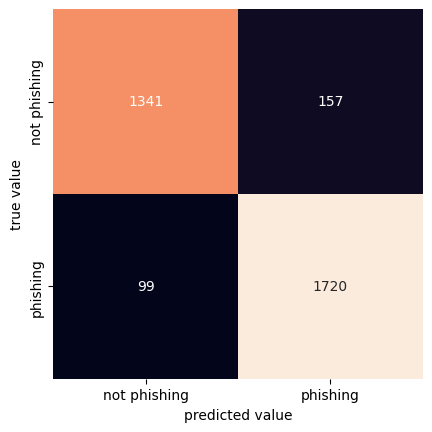

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [22]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# TO DO: Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
1. Yes, the dataset is imbalanced. From the class histogram, we can observe that there are more "Phishing" samples (6,157) than "Not phishing" samples (4,898). While the imbalance is not extreme, it could still affect model performance, as the model might be biased towards the "Phishing" class, potentially leading to more false negatives if it overfits.

2. For the Full dataset(X, y), since the training accuracy (93.23%) and testing accuracy (92.28%) are close to each other, that indicates is only very slightly overfitting and the model generalizes well overall. For the First two columns of X and y dataset, the low training accuracy (56.28%) and testing accuracy (55.68%) suggests that the model is underfitting when only using the first two columns of X. This results in poor performance on both training and testing sets. For the smaller dataset, the model performs well when it comes to training accuracy (94.37%) and testing accuracy (91.00%). There is a slight difference between the accuracies, suggesting slight overfitting possibly due to the limited data.

3. With a full dataset, the model achieves high accuracy on both training (93.23%) and testing (92.28%) sets. With only two features, both training and testing accuracies drop to 56.28% and 55.68% respectively, suggesting that the model does not have enough information/data and leads to underfitting. With a smaller dataset, the training accuracy increases to 94.37% but the testing accuracy decreases to 91.00%, which suggests slight overfitting, as the model can memorize the smaller training set more easily but struggles to generalize as well on the testing set.

4. A false positive occurs when the model incorrectly classifies a non-phishing website as phishing, our confusion matrix has 157 false positives. A false negative occurs when the model incorrectly classifies a phishing website as non-phishing, our confusion matrix has 99 false negatives. In our case, a false negative is worse because failing to detect a phishing website exposes users to security risks, so it's more important to minimize the chance of a phishing site going undetected, as opposed to occasionally flagging legitimate sites as phishing.

5. Since false negatives are more harmful in our case, we would want to maximize recall for the phishing class. That means the model will catch as many phishing websites as possible, reducing the number of false negatives. In order to do this, we could lower the decision threshold for classifying a website as phishing, which will make the model more lenient in labeling sites as phishing. We could also use class weighting which gives higher weight to the minority class if phishing websites are underrepresented. This would make the model more sensitive to phishing samples, increasing recall for the phishing class.

6. For the Full dataset, a low Log Loss (0.190) suggests that the model is confident and accurate in its predictions. For the First two colums of X and y dataset, a high Log Loss (0.684) suggests that the model is less confident in its predictions and struggles to accurately classify samples with only two features. For the Smaller dataset, the Log Loss is 0.200 which is higher than the Full dataset but still relatively low. This suggests that the model performs reasonably well on the smaller dataset, but the reduced sample size leads to slightly less confident predictions and minor overfitting. The differences in Log Loss are due to the amount of data and number of features available. The more data and features available results in a lower Log Loss and more confident predictions, while reduced features and smaller dataset leads to higher uncertainty and less reliable predictions.

---